<a href="https://colab.research.google.com/github/GiuliadeInnocentiis/Bayesian-Survival-Analysis/blob/main/Neural%20fitted%20q%20iteration%20with%20conformal%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration FQI: 1/400
Iteration FQI: 2/400
Iteration FQI: 3/400
Iteration FQI: 4/400
Iteration FQI: 5/400
Iteration FQI: 6/400
Iteration FQI: 7/400
Iteration FQI: 8/400
Iteration FQI: 9/400
Iteration FQI: 10/400
Iteration FQI: 11/400
Iteration FQI: 12/400
Iteration FQI: 13/400
Iteration FQI: 14/400
Iteration FQI: 15/400
Iteration FQI: 16/400
Iteration FQI: 17/400
Iteration FQI: 18/400
Iteration FQI: 19/400
Iteration FQI: 20/400
Iteration FQI: 21/400
Iteration FQI: 22/400
Iteration FQI: 23/400
Iteration FQI: 24/400
Iteration FQI: 25/400
Iteration FQI: 26/400
Iteration FQI: 27/400
Iteration FQI: 28/400
Iteration FQI: 29/400
Iteration FQI: 30/400
Iteration FQI: 31/400
Iteration FQI: 32/400
Iteration FQI: 33/400
Iteration FQI: 34/400
Iteration FQI: 35/400
Iteration FQI: 36/400
Iteration FQI: 37/400
Iteration FQI: 38/400
Iteration FQI: 39/400
Iteration FQI: 40/400
Iteration FQI: 41/400
Iteration FQI: 42/400
Iteration FQI: 43/400
Iteration FQI: 44/400
Iteration FQI: 45/400
Iteration FQI: 46/4

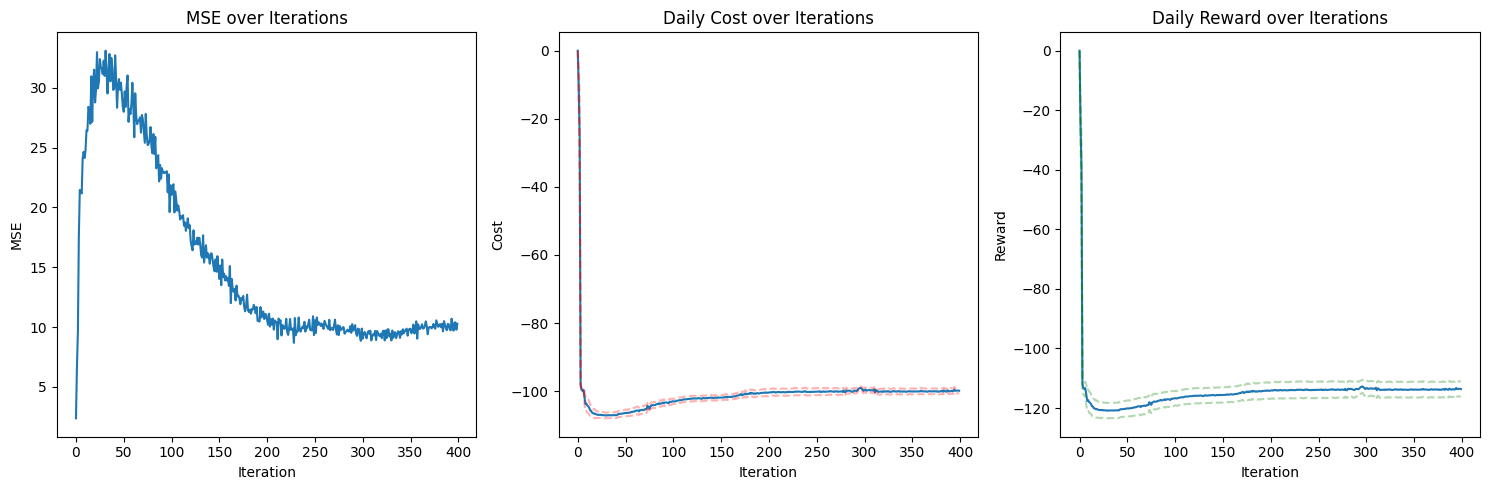

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(123)
torch.manual_seed(123)
python_random_seed = 123

# Load and prepare data
dati = pd.read_csv("water_tank.csv").iloc[:, 1:]
lambda_val = 0.2
dati['reward_new'] = dati['reward'] - lambda_val * (dati['stato_succ'] - dati['stato'])**2

# Split data
index = range(7200)
training = dati.iloc[index].copy()
test = dati.drop(index).copy()

# Parameters
gamma = 1  # discount factor
azioni_possibili = np.arange(0, 10, 0.5)
n_iter = 400 # number of FQI iterations

# Initialize metrics storage
mse = np.zeros(n_iter)
media_costo = np.zeros(n_iter)
std_costo = np.zeros(n_iter)
media_reward = np.zeros(n_iter)
std_reward = np.zeros(n_iter)

# Define groups for daily aggregation (24 hours)
gruppi = np.repeat(np.arange(len(training)//24), 24)

# Define neural network
class QNetwork(nn.Module):
    def __init__(self, input_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2= nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Prepare data
scaler = StandardScaler()
X_train = training[['stato', 'azione']].values
X_scaled = scaler.fit_transform(X_train)
y_train = training['reward_new'].values.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_train)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
input_size = X_train.shape[1]
q_mod = QNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(q_mod.parameters(), lr=0.001)

# Define price array
prices = np.array([1]*6 + [3]*2 + [2]*10 + [3]*2 + [2]*2 + [1]*2)
eta = 0.85

# Fitted Q-Iteration
# Get all unique states from the entire dataset
all_unique_states = pd.concat([training['stato'], training['stato_succ'], test['stato'], test['stato_succ']]).unique()

# Create a mapping from state to index
state_to_index = {state: i for i, state in enumerate(all_unique_states)}

for k in range(n_iter):
    print(f"Iteration FQI: {k+1}/{n_iter}")

    target_q = training['reward_new'].values.copy()

    if k > 0:
        # Pre-calcolo tutti i Q-values per stati unici
        # Process in batches for efficiency
        batch_size = 1024
        q_next = np.zeros((2, len(all_unique_states)))  # 2 rows: max_q and optimal_action

        for i in range(0, len(all_unique_states), batch_size):
            batch_states = all_unique_states[i:i+batch_size]

            # Create all possible state-action pairs
            state_action_pairs = np.array([
                [s, a] for s in batch_states for a in azioni_possibili
            ])

            # Scale and predict
            state_action_scaled = scaler.transform(state_action_pairs)
            with torch.no_grad():
                q_preds = q_mod(torch.FloatTensor(state_action_scaled)).numpy().flatten()
                q_preds = q_preds.reshape(len(batch_states), len(azioni_possibili))

                # Store max Q and optimal action
                q_next[0, i:i+len(batch_states)] = np.max(q_preds, axis=1)
                q_next[1, i:i+len(batch_states)] = azioni_possibili[np.argmax(q_preds, axis=1)]

        # Update target Q for non-terminal states
        not_done = training['done'] != 1
        # Use the state_to_index mapping to get the correct index for each successor state
        idx = [state_to_index[s] for s in training['stato_succ']]
        target_q[not_done] += gamma * q_next[0, idx][not_done]

        # Calculate daily costs and rewards
        temp_actions = q_next[1, idx]

        # Cost calculation
        costo_temp = -prices[np.tile(np.arange(24), len(training)//24)] * (1/eta) * (temp_actions**(1/3))
        costo_daily = np.array([np.sum(costo_temp[gruppi == g]) for g in np.unique(gruppi)])
        media_costo[k] = np.mean(costo_daily)
        std_costo[k] = np.std(costo_daily)

        # Reward calculation
        reward_temp = costo_temp - lambda_val * (training['stato_succ'] - training['stato'])**2
        reward_daily = np.array([np.sum(reward_temp[gruppi == g]) for g in np.unique(gruppi)])
        media_reward[k] = np.mean(reward_daily)
        std_reward[k] = np.std(reward_daily)


    # Update y_tensor with new target_q
    y_tensor = torch.FloatTensor(target_q.reshape(-1, 1))
    dataset = TensorDataset(X_tensor, y_tensor)

    # Train the model
    q_mod.train()
    for epoch in range(10):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = q_mod(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Compute MSE
    with torch.no_grad():
        predictions = q_mod(X_tensor)
        mse[k] = criterion(predictions, y_tensor).item()

# Optimal action function
def optimal_action(state, model, scaler):
    state_action_pairs = np.column_stack([
        np.full(len(azioni_possibili), state),
        azioni_possibili
    ])
    state_action_scaled = scaler.transform(state_action_pairs)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_action_scaled)).numpy().flatten()
    return azioni_possibili[np.argmax(q_values)]

# Test the policy
test_states = test['stato'].values
test_actions = np.array([optimal_action(s, q_mod, scaler) for s in test_states])

# Calculate costs
test['hour'] = np.tile(np.arange(24), len(test)//24 + 1)[:len(test)] % 24
cost = prices[test['hour']] * (1/eta) * (test_actions**(1/3))

print("Cost difference:", np.sum(cost + test['reward'].values))

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(mse)
plt.title('MSE over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(media_costo, label='Mean Cost')
plt.plot(media_costo + std_costo, 'r--', alpha=0.3)
plt.plot(media_costo - std_costo, 'r--', alpha=0.3)
plt.title('Daily Cost over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.subplot(1, 3, 3)
plt.plot(media_reward, label='Mean Reward')
plt.plot(media_reward + std_reward, 'g--', alpha=0.3)
plt.plot(media_reward - std_reward, 'g--', alpha=0.3)
plt.title('Daily Reward over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Reward')

plt.tight_layout()
plt.show()

In [ ]:
#Mi salvo i dati che servono per fare grafico reward
dati_reward = pd.DataFrame({'media_reward': media_reward, 'std_reward': std_reward, 'iterazione': np.arange(1, n_iter+1), 'lower':media_reward - std_reward, 'upper': media_reward + std_reward})
dati_reward.to_csv('dati_reward.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd

# Optimal action function
def optimal_action(state, model, scaler):
    state_action_pairs = np.column_stack([
        np.full(len(azioni_possibili), state),
        azioni_possibili
    ])
    state_action_scaled = scaler.transform(state_action_pairs)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_action_scaled)).numpy().flatten()
    return azioni_possibili[np.argmax(q_values)]


# Calcolo della domanda (equivalente a domanda <- test$stato + test$azione - test$stato_succ)
domanda = test['stato'] + test['azione'] - test['stato_succ']

# Inizializzazione degli array (equivalente a numeric(nrow(test)))
stato_nuovo = np.zeros(len(test)+1 )  # +1 perché salviamo anche lo stato finale
stato_nuovo[0] = test['stato'].iloc[0]  # Stato iniziale

azione_ottima = np.zeros(len(test))
done = test['done'].values
stato_oss = test['stato'].values

# Simulazione del sistema
for i in range(len(test)):
    azione_ottima[i] = optimal_action(stato_nuovo[i], q_mod, scaler)
    if done[i] == 0:
        # Caso non terminale
        stato_nuovo[i+1] = stato_nuovo[i] + azione_ottima[i] - domanda.iloc[i]
    else:

        if i + 1 < len(stato_oss):
            stato_nuovo[i+1] = stato_oss[i+1]
        else:
            # Se i+1 è fuori dai limiti, mantieni l'ultimo stato osservato
            stato_nuovo[i+1] = stato_oss[i]

# Analisi dei risultati (equivalente ai comandi R finali)
stato_nuovo = stato_nuovo[:-1]
# Tabella delle azioni ottimali
print("Distribuzione delle azioni ottimali:")
print(pd.Series(azione_ottima).value_counts().sort_index())

# Statistiche dello stato
print("\nStatistiche degli stati:")
print(pd.Series(stato_nuovo).describe())

# Conteggio stati <= 5 e >= 50
print(f"\nNumero di stati <= 5: {np.sum(stato_nuovo <= 5)}")
print(f"Numero di stati >= 50: {np.sum(stato_nuovo >= 50)}")
prices = np.concatenate([
    np.ones(6),       # rep(1,6)
    np.full(2, 3),    # rep(3,2)
    np.full(10, 2),   # rep(2,10)
    np.full(2, 3),    # rep(3,2)
    np.full(2, 2),    # rep(2,2)
    np.full(2, 1)     # rep(1,2)
])

eta = 0.85

# Calcolo del costo (adattato alla tua struttura)
# Assumendo che azione_ottima sia un array numpy di lunghezza 24*65=1560
costo = np.tile(prices, 65) * (1/eta) * np.power(azione_ottima, 1/3)

# Calcolo del costo totale (nota: - -test$reward equivale a + test$reward)
# Assumendo che test['reward'] sia una Series pandas o array numpy
total_cost = np.sum(costo + test['reward'].values)

print(f"Costo totale: {total_cost}")

Distribuzione delle azioni ottimali:
5.5       4
6.0      48
6.5     168
7.0     203
7.5      64
8.0      26
8.5      13
9.0      19
9.5    1015
Name: count, dtype: int64

Statistiche degli stati:
count    1560.000000
mean       25.323952
std         8.858672
min        12.130000
25%        18.530400
50%        21.119900
75%        36.024525
max        43.888500
dtype: float64

Numero di stati <= 5: 0
Numero di stati >= 50: 0
Costo totale: -202.16463515831535


In [ ]:
prices = np.concatenate([
    np.ones(6),       # rep(1,6)
    np.full(2, 3),    # rep(3,2)
    np.full(10, 2),   # rep(2,10)
    np.full(2, 3),    # rep(3,2)
    np.full(2, 2),    # rep(2,2)
    np.full(2, 1)     # rep(1,2)
])

eta = 0.85

# Calcolo del costo (adattato alla tua struttura)
# Assumendo che azione_ottima sia un array numpy di lunghezza 24*65=1560
costo = np.tile(prices, 65) * (1/eta) * np.power(azione_ottima, 1/3)

# Calcolo del costo totale (nota: - -test$reward equivale a + test$reward)
# Assumendo che test['reward'] sia una Series pandas o array numpy
total_cost = np.sum(costo + test['reward'].values)

print(f"Costo totale: {total_cost}")

Costo totale: -202.16463515831535


In [ ]:
#Faccio su tutto il dataset
import numpy as np
import pandas as pd

# Optimal action function
def optimal_action(state, model, scaler):
    state_action_pairs = np.column_stack([
        np.full(len(azioni_possibili), state),
        azioni_possibili
    ])
    state_action_scaled = scaler.transform(state_action_pairs)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_action_scaled)).numpy().flatten()
    return azioni_possibili[np.argmax(q_values)]

# Calcolo della domanda (equivalente a domanda <- test$stato + test$azione - test$stato_succ)
domanda = dati['stato'] + dati['azione'] - dati['stato_succ']

# Inizializzazione degli array (equivalente a numeric(nrow(test)))
stato_nuovo = np.zeros(len(dati)+1 )  # +1 perché salviamo anche lo stato finale
stato_nuovo[0] = dati['stato'].iloc[0]  # Stato iniziale

azione_ottima = np.zeros(len(dati))
done = dati['done'].values

for i in range(len(dati)):
    azione_ottima[i] = optimal_action(stato_nuovo[i], q_mod, scaler)
    stato_nuovo[i+1] = stato_nuovo[i] + azione_ottima[i] - domanda.iloc[i]

# Analisi dei risultati (equivalente ai comandi R finali)
stato_nuovo = stato_nuovo[:-1]
# Tabella delle azioni ottimali
print("Distribuzione delle azioni ottimali:")
print(pd.Series(azione_ottima).value_counts().sort_index())
print(pd.Series(azione_ottima).describe())

# Statistiche dello stato
print("\nStatistiche degli stati:")
print(pd.Series(stato_nuovo).describe())

# Conteggio stati <= 5 e >= 50
print(f"\nNumero di stati <= 5: {np.sum(stato_nuovo <= 5)}")
print(f"Numero di stati >= 50: {np.sum(stato_nuovo >= 50)}")

Distribuzione delle azioni ottimali:
5.0       1
5.5       1
6.5       4
7.0      21
7.5      99
8.0     294
8.5     577
9.0     310
9.5    7453
Name: count, dtype: int64
count    8760.000000
mean        9.335160
std         0.437623
min         5.000000
25%         9.500000
50%         9.500000
75%         9.500000
max         9.500000
dtype: float64

Statistiche degli stati:
count    8760.000000
mean       18.145527
std         5.605316
min         6.222200
25%        14.064350
50%        16.677050
75%        21.923350
max        46.166300
dtype: float64

Numero di stati <= 5: 0
Numero di stati >= 50: 0


In [ ]:
#Prezzo sul dataset completo
prices = np.concatenate([
    np.ones(6),       # rep(1,6)
    np.full(2, 3),    # rep(3,2)
    np.full(10, 2),   # rep(2,10)
    np.full(2, 3),    # rep(3,2)
    np.full(2, 2),    # rep(2,2)
    np.full(2, 1)     # rep(1,2)
])

eta = 0.85

# Calcolo del costo (adattato alla tua struttura)
# Assumendo che azione_ottima sia un array numpy di lunghezza 24*65=1560
costo = np.tile(prices, 365) * (1/eta) * np.power(azione_ottima, 1/3)

# Calcolo del costo totale (nota: - -test$reward equivale a + test$reward)
# Assumendo che test['reward'] sia una Series pandas o array numpy
total_cost = np.sum(costo + dati['reward'].values)

print(f"Costo totale: {total_cost}")

Costo totale: -285.96707664114524


In [ ]:
dati_azione=pd.DataFrame ({'azione' : azione_ottima, 'stato' : stato_nuovo, 'costo' : costo})
dati_azione.to_csv('dati_azione_sdg.csv', index=False)

In [ ]:
#CODICE PER CONFORMAL PREDICTION
###
##
##
#

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(123)
torch.manual_seed(123)
python_random_seed = 123

# Load and prepare data
dati = pd.read_csv("water_tank.csv").iloc[:, 1:]
lambda_val = 0.2
dati['reward_new'] = dati['reward'] - lambda_val * (dati['stato_succ'] - dati['stato'])**2

#aggiungo il tempo
tempo = np.tile(np.arange(1, 25), len(dati)//24)
dati['tempo'] = tempo[:len(dati)]
# Split data
#Conformal prediction
#divido in training, calibration e test
index = range(7200)
training = dati.iloc[index].copy()
test = dati.drop(index).copy()

#divido in calibration
idx=range(6120)
train_dd=training.iloc[idx].copy()
cal = training.drop(idx).copy()

# Parameters
gamma = 1  # discount factor
azioni_possibili = np.arange(0, 10, 0.5)
n_iter = 400 # number of FQI iterations



# Define groups for daily aggregation (24 hours)
gruppi = np.repeat(np.arange(len(train_dd)//24), 24)

# Define neural network
class QNetwork(nn.Module):
    def __init__(self, input_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Prepare data
scaler = StandardScaler()
X_train = train_dd[['stato', 'azione']].values
X_scaled = scaler.fit_transform(X_train)
y_train = train_dd['reward_new'].values.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_train)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
input_size = X_train.shape[1]
q_mod = QNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(q_mod.parameters(), lr=0.001)

# Define price array
prices = np.array([1]*6 + [3]*2 + [2]*10 + [3]*2 + [2]*2 + [1]*2)
eta = 0.85

# Fitted Q-Iteration
# Get all unique states from the entire dataset
all_unique_states = pd.concat([training['stato'], training['stato_succ'], test['stato'], test['stato_succ']]).unique()

# Create a mapping from state to index
state_to_index = {state: i for i, state in enumerate(all_unique_states)}

for k in range(n_iter):
    print(f"Iteration FQI: {k+1}/{n_iter}")

    target_q = train_dd['reward_new'].values.copy()

    if k > 0:
        # Pre-calcolo tutti i Q-values per stati unici
        # Process in batches for efficiency
        batch_size = 1024
        q_next = np.zeros((2, len(all_unique_states)))  # 2 rows: max_q and optimal_action

        for i in range(0, len(all_unique_states), batch_size):
            batch_states = all_unique_states[i:i+batch_size]

            # Create all possible state-action pairs
            state_action_pairs = np.array([
                [s, a] for s in batch_states for a in azioni_possibili
            ])

            # Scale and predict
            state_action_scaled = scaler.transform(state_action_pairs)
            with torch.no_grad():
                q_preds = q_mod(torch.FloatTensor(state_action_scaled)).numpy().flatten()
                q_preds = q_preds.reshape(len(batch_states), len(azioni_possibili))

                # Store max Q and optimal action
                q_next[0, i:i+len(batch_states)] = np.max(q_preds, axis=1)
                q_next[1, i:i+len(batch_states)] = azioni_possibili[np.argmax(q_preds, axis=1)]

        # Update target Q for non-terminal states
        not_done = train_dd['done'] != 1
        # Use the state_to_index mapping to get the correct index for each successor state
        idx = [state_to_index[s] for s in train_dd['stato_succ']]
        target_q[not_done] += gamma * q_next[0, idx][not_done]

        # Calculate daily costs and rewards
        temp_actions = q_next[1, idx]


    # Update y_tensor with new target_q
    y_tensor = torch.FloatTensor(target_q.reshape(-1, 1))
    dataset = TensorDataset(X_tensor, y_tensor)

    # Train the model
    q_mod.train()
    for epoch in range(10):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = q_mod(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Compute MSE
    with torch.no_grad():
        predictions = q_mod(X_tensor)
        mse[k] = criterion(predictions, y_tensor).item()



Iteration FQI: 1/400
Iteration FQI: 2/400
Iteration FQI: 3/400
Iteration FQI: 4/400
Iteration FQI: 5/400
Iteration FQI: 6/400
Iteration FQI: 7/400
Iteration FQI: 8/400
Iteration FQI: 9/400
Iteration FQI: 10/400
Iteration FQI: 11/400
Iteration FQI: 12/400
Iteration FQI: 13/400
Iteration FQI: 14/400
Iteration FQI: 15/400
Iteration FQI: 16/400
Iteration FQI: 17/400
Iteration FQI: 18/400
Iteration FQI: 19/400
Iteration FQI: 20/400
Iteration FQI: 21/400
Iteration FQI: 22/400
Iteration FQI: 23/400
Iteration FQI: 24/400
Iteration FQI: 25/400
Iteration FQI: 26/400
Iteration FQI: 27/400
Iteration FQI: 28/400
Iteration FQI: 29/400
Iteration FQI: 30/400
Iteration FQI: 31/400
Iteration FQI: 32/400
Iteration FQI: 33/400
Iteration FQI: 34/400
Iteration FQI: 35/400
Iteration FQI: 36/400
Iteration FQI: 37/400
Iteration FQI: 38/400
Iteration FQI: 39/400
Iteration FQI: 40/400
Iteration FQI: 41/400
Iteration FQI: 42/400
Iteration FQI: 43/400
Iteration FQI: 44/400
Iteration FQI: 45/400
Iteration FQI: 46/4

In [ ]:
# Optimal action function
np.random.seed(123)
torch.manual_seed(123)
python_random_seed = 123


giorno = np.repeat(np.arange(len(cal)//24), 24)
cal = cal.copy()
cal['giorno'] = giorno[:len(cal)]



def optimal_action(state, model, scaler):
    state_action_pairs = np.column_stack([
        np.full(len(azioni_possibili), state),
        azioni_possibili
    ])
    state_action_scaled = scaler.transform(state_action_pairs)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_action_scaled)).numpy().flatten()
    return azioni_possibili[np.argmax(q_values)]
from sklearn.linear_model import LogisticRegression
# Conformal Prediction
# Create dataset with observed and optimal actions DAL TRAIN
indice_oss = range(480)

azione_behav = train_dd['azione'].iloc[indice_oss].values
stato_behav = train_dd['stato'].iloc[indice_oss].values
statosucc_behav = train_dd['stato_succ'].iloc[indice_oss].values
done_behav = train_dd['done'].iloc[indice_oss].values

# Update state with new policy
domanda = stato_behav + azione_behav - statosucc_behav

stato_nuovo_b = np.zeros(len(stato_behav) + 1)
stato_nuovo_b[0] = stato_behav[0]
azione_ottima_t = np.zeros(len(stato_behav))
done = done_behav
stato_oss = stato_behav

for i in range(len(stato_behav)):
    if done[i] == 0:
        azione_ottima_t[i] = optimal_action(stato_nuovo_b[i], q_mod, scaler)
        stato_nuovo_b[i+1] = stato_nuovo_b[i] + azione_ottima_t[i] - domanda[i]
    else:
        azione_ottima_t[i] = optimal_action(stato_nuovo_b[i], q_mod, scaler)
        if i + 1 < len(stato_oss):
            stato_nuovo_b[i+1] = stato_oss[i+1]
        else:
            stato_nuovo_b[i+1] = stato_oss[i]

# Logistic regression for weights
dd = pd.DataFrame({
    'y': np.concatenate([np.ones(480), np.zeros(480)]),
    'azioni': np.concatenate([azione_behav, azione_ottima_t])
})
dd['azioni'] = np.round(dd['azioni'] * 2) / 2  # Round to nearest 0.5

mod_log = LogisticRegression()
mod_log.fit(dd[['azioni']], dd['y'])

# Optimal action for calibration with Q-values
# Update calibration set with new policy

def optimal_action_cal(state, model, scaler):
    state_action_pairs = np.column_stack([
        np.full(len(azioni_possibili), state),
        azioni_possibili
    ])
    state_action_scaled = scaler.transform(state_action_pairs)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_action_scaled)).numpy().flatten()
    return np.max(q_values), azioni_possibili[np.argmax(q_values)]



domanda_cal = cal['stato'] + cal['azione'] - cal['stato_succ']
stato_nuovo_c = np.zeros(len(cal) + 1)
stato_nuovo_c[0] = cal['stato'].iloc[0]
azione_ottima_c = np.zeros(len(cal))
q_val_cal = np.zeros(len(cal))

for i in range(len(cal)):
    if cal['done'].iloc[i] == 0:
        q_val_cal[i], azione_ottima_c[i] = optimal_action_cal(stato_nuovo_c[i], q_mod, scaler)
        stato_nuovo_c[i+1] = stato_nuovo_c[i] + azione_ottima_c[i] - domanda_cal.iloc[i]
    else:
        q_val_cal[i], azione_ottima_c[i] = optimal_action_cal(stato_nuovo_c[i], q_mod, scaler)
        if i + 1 < len(cal):
            stato_nuovo_c[i+1] = cal['stato'].iloc[i+1]
        else:
            stato_nuovo_c[i+1] = cal['stato'].iloc[i]

# Calculate weights
pesi = mod_log.predict_proba(azione_ottima_c.reshape(-1, 1))[:, 1]
pesi_norm = pesi / (1 - pesi)

# Calculate scores
tempo = np.tile(np.arange(1, 25), len(cal)//24)
giorno = np.repeat(np.arange(len(cal)//24), 24)
cal = cal.copy()
cal['tempo'] = tempo[:len(cal)]
cal['giorno'] = giorno[:len(cal)]

q_val_cal_m = q_val_cal.reshape(len(cal)//24, 24)
score = np.full((len(cal)//24, 24), np.nan)

for g in range(len(cal)//24):
    for t in range(24):
       score[g, t] = abs(np.sum(cal.loc[cal['giorno'] == g, 'reward_new'].iloc[t:]) - q_val_cal_m[g, t])

score = score.flatten()

score_pesati = score* pesi_norm
ord_score = np.sort(score_pesati)
n = len(cal)
q_val = np.ceil((n + 1) * (1 - 0.1)).astype(int)
eq = ord_score[q_val - 1]  # -1 because Python is 0-indexed


domanda_test = test['stato'] + test['azione'] - test['stato_succ']
stato_nuovo_test = np.zeros(len(test) + 1)
stato_nuovo_test = test['stato'].iloc()
azione_ottima_test = np.zeros(len(test))
q_val_test = np.zeros(len(test))

for i in range(len(test)):
    if test['done'].iloc[i] == 0:
        q_val_test[i], azione_ottima_test[i] = optimal_action_cal(stato_nuovo_test[i], q_mod, scaler)
        #stato_nuovo_test[i+1] = stato_nuovo_test[i] + azione_ottima_test[i] - domanda_test.iloc[i]
    else:
        q_val_test[i], azione_ottima_test[i] = optimal_action_cal(stato_nuovo_test[i], q_mod, scaler)


# Prediction intervals
PI = pd.DataFrame({
    'q_values': q_val_test,
    'PI_lower': q_val_test - eq,
    'PI_upper': q_val_test + eq
})

print("Conformal prediction completed!")
print(f"Prediction interval half-width: {eq}")
print(PI.head())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Conformal prediction completed!
Prediction interval half-width: 119.09460802205552
   q_values    PI_lower    PI_upper
0 -2.195060 -121.289668  116.899548
1 -2.461734 -121.556342  116.632874
2 -2.500282 -121.594890  116.594326
3 -2.543557 -121.638165  116.551051
4 -2.461254 -121.555862  116.633354


In [ ]:
#Coverage
import numpy as np
import pandas as pd

# Assumendo che 'test' sia un DataFrame pandas
n = len(test)
giorni = np.repeat(np.arange(1, n//24 + 1), 24)
test['giorno'] = giorni

reward_cum = []
score = []

for j in np.unique(giorni):
    reward_test = test.loc[test['giorno'] == j, 'reward_new'].values
    score_temp = []

    for i in range(len(reward_test)):
        # Somma cumulativa dalla posizione i alla fine
        score_temp.append(np.sum(reward_test[i:]))

    reward_cum.extend(score_temp)
    score = []  # Re-inizializza score per il prossimo giorno

# Converti reward_cum in array numpy per facilità di accesso
reward_cum = np.array(reward_cum)



coverage = np.mean((reward_cum < PI['PI_upper']) & (reward_cum > PI['PI_lower']))
int_len = round(np.mean(PI['PI_upper'] - PI['PI_lower']), 5)

print(f"Coverage: {coverage}")
print(f"Lunghezza intervallo medio: {int_len}")

reward_cum[1:24]: [-121.8507492  -118.305194   -116.05005648 -113.82475239 -111.53627616
 -109.27450342 -106.44764982  -96.82358153  -87.74413305  -81.53985768
  -75.77379323  -70.2391242   -65.16981264  -59.86228185  -54.7543498
  -49.50576375  -44.38688287  -39.05861959  -33.81630239  -26.21180616
  -18.53338852  -12.60677729   -7.24286375   -4.45238631]
PI$q_values[1:24]: 0    -2.212772
1    -2.496914
2    -2.536345
3    -2.580882
4    -2.480922
5    -2.451454
6    -2.247749
7    -1.967348
8    -2.470843
9    -2.671111
10   -3.244338
11   -4.306066
12   -4.300763
13   -3.540607
14   -3.235235
15   -2.886068
16   -2.764985
17   -3.067368
18   -3.668314
19   -3.706251
20   -3.282135
21   -2.649007
22   -2.479532
23   -2.489710
Name: q_values, dtype: float64
Coverage: 0.5903846153846154
Lunghezza intervallo medio: 154.62792


In [ ]:
print(eq)
print(PI.describe())
PI.to_csv('prediction_intervals_baseline.csv', index=False)

77.31395754369403
          q_values     PI_lower     PI_upper
count  1560.000000  1560.000000  1560.000000
mean     -2.677635   -79.991593    74.636322
std       0.568059     0.568059     0.568059
min      -5.853154   -83.167111    71.460804
25%      -2.798310   -80.112267    74.515648
50%      -2.505795   -79.819753    74.808162
75%      -2.406285   -79.720243    74.907672
max      -1.954918   -79.268876    75.359039


In [ ]:
print(PI)

      q_values   PI_lower   PI_upper
0    -2.212772 -79.526730  75.101185
1    -2.496914 -79.810872  74.817043
2    -2.536345 -79.850303  74.777613
3    -2.580882 -79.894839  74.733076
4    -2.480922 -79.794879  74.833036
...        ...        ...        ...
1555 -2.446521 -79.760478  74.867437
1556 -2.271297 -79.585254  75.042661
1557 -1.968457 -79.282415  75.345501
1558 -2.058091 -79.372048  75.255867
1559 -2.203305 -79.517263  75.110652

[1560 rows x 3 columns]


In [ ]:
#CON SUBSAMPLE

# Optimal action function
np.random.seed(123)
torch.manual_seed(123)
python_random_seed = 123

import numpy as np
import pandas as pd

idx=range(6120)
train_dd=training.iloc[idx].copy()
cal = training.drop(idx).copy()
tempo = np.tile(np.arange(1, 25), len(cal)//24)
giorno = np.repeat(np.arange(len(cal)//24), 24)
cal = cal.copy()
cal['tempo'] = tempo[:len(cal)]
cal['giorno'] = giorno[:len(cal)]

# Se 'cal' è un DataFrame pandas
ind = np.random.choice(1080, 480, replace=False)
ind = np.sort(ind)
cal = cal.iloc[ind, :]



from sklearn.linear_model import LogisticRegression
# Conformal Prediction
# Create dataset with observed and optimal actions DAL TRAIN
indice_oss = range(480)

azione_behav = train_dd['azione'].iloc[indice_oss].values
stato_behav = train_dd['stato'].iloc[indice_oss].values
statosucc_behav = train_dd['stato_succ'].iloc[indice_oss].values
done_behav = train_dd['done'].iloc[indice_oss].values

# Update state with new policy
domanda = stato_behav + azione_behav - statosucc_behav

stato_nuovo_b = np.zeros(len(stato_behav) + 1)
stato_nuovo_b[0] = stato_behav[0]
azione_ottima_t = np.zeros(len(stato_behav))
done = done_behav
stato_oss = stato_behav

for i in range(len(stato_behav)):
    if done[i] == 0:
        azione_ottima_t[i] = optimal_action(stato_nuovo_b[i], q_mod, scaler)
        stato_nuovo_b[i+1] = stato_nuovo_b[i] + azione_ottima_t[i] - domanda[i]
    else:
        azione_ottima_t[i] = optimal_action(stato_nuovo_b[i], q_mod, scaler)
        if i + 1 < len(stato_oss):
            stato_nuovo_b[i+1] = stato_oss[i+1]
        else:
            stato_nuovo_b[i+1] = stato_oss[i]

# Logistic regression for weights
dd = pd.DataFrame({
    'y': np.concatenate([np.ones(480), np.zeros(480)]),
    'azioni': np.concatenate([azione_behav, azione_ottima_t])
})
dd['azioni'] = np.round(dd['azioni'] * 2) / 2  # Round to nearest 0.5

mod_log = LogisticRegression()
mod_log.fit(dd[['azioni']], dd['y'])

# Optimal action for calibration with Q-values
# Update calibration set with new policy

def optimal_action_cal(state, model, scaler):
    state_action_pairs = np.column_stack([
        np.full(len(azioni_possibili), state),
        azioni_possibili
    ])
    state_action_scaled = scaler.transform(state_action_pairs)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_action_scaled)).numpy().flatten()
    return np.max(q_values), azioni_possibili[np.argmax(q_values)]



domanda_cal = cal['stato'] + cal['azione'] - cal['stato_succ']
stato_nuovo_c = np.zeros(len(cal) + 1)
stato_nuovo_c[0] = cal['stato'].iloc[0]
azione_ottima_c = np.zeros(len(cal))
q_val_cal = np.zeros(len(cal))

for i in range(len(cal)):
    if cal['done'].iloc[i] == 0:
        q_val_cal[i], azione_ottima_c[i] = optimal_action_cal(stato_nuovo_c[i], q_mod, scaler)
        stato_nuovo_c[i+1] = stato_nuovo_c[i] + azione_ottima_c[i] - domanda_cal.iloc[i]
    else:
        q_val_cal[i], azione_ottima_c[i] = optimal_action_cal(stato_nuovo_c[i], q_mod, scaler)
        if i + 1 < len(cal):
            stato_nuovo_c[i+1] = cal['stato'].iloc[i+1]
        else:
            stato_nuovo_c[i+1] = cal['stato'].iloc[i]

# Calculate weights
pesi = mod_log.predict_proba(azione_ottima_c.reshape(-1, 1))[:, 1]
pesi_norm = pesi / (1 - pesi)

# Calculate scores
#tempo = np.tile(np.arange(1, 25), len(cal)//24)
#giorno = np.repeat(np.arange(len(cal)//24), 24)
#cal = cal.copy()
#cal['tempo'] = tempo[:len(cal)]
#cal['giorno'] = giorno[:len(cal)]

#q_val_cal_m = q_val_cal.reshape(len(cal)//24, 24)
#score = np.full((len(cal)//24, 24), np.nan)

#for g in range(len(cal)//24):
  #  for t in range(24):
 #       score[g, t] = np.sum(cal.loc[cal['giorno'] == g, 'reward_new'].iloc[t:]) - q_val_cal_m[g, t]

#score = score.flatten()


# Supponendo che 'cal' sia un DataFrame pandas
giorni = cal['giorno'].unique()
score = []
score1 = []

for j in giorni:
    # Filtra i reward per il giorno corrente
    reward_cal = cal.loc[cal['giorno'] == j, 'reward_new'].values
      # Assumendo che q_val esista

    for i in range(len(reward_cal)):
        # Calcola la somma cumulativa dalla posizione i alla fine
        cumulative_sum = np.sum(reward_cal[i:])
        # Sottrae il valore q_val corrispondente
        score.append(abs(cumulative_sum - q_val_cal[i]))

    # Aggiunge i risultati al punteggio totale
    score1.extend(score)
    score = []  # Resetta la lista per il prossimo giorno

# Converti in array numpy se necessario
score1 = np.array(score1)

score_pesati = score1 * pesi_norm
ord_score = np.sort(score_pesati)
n = len(cal)
q_val = np.ceil((n + 1) * (1 - 0.1)).astype(int)
eq = ord_score[q_val - 1]  # -1 because Python is 0-indexed
#

domanda_test = test['stato'] + test['azione'] - test['stato_succ']
#stato_nuovo_test = np.zeros(len(test) + 1)
stato_nuovo_test = test['stato'].iloc()
azione_ottima_test = np.zeros(len(test))
q_val_test = np.zeros(len(test))

for i in range(len(test)):
    if test['done'].iloc[i] == 0:
        q_val_test[i], azione_ottima_test[i] = optimal_action_cal(stato_nuovo_test[i], q_mod, scaler)
        #stato_nuovo_test[i+1] = stato_nuovo_test[i] + azione_ottima_test[i] - domanda_test.iloc[i]
    else:
        q_val_test[i], azione_ottima_test[i] = optimal_action_cal(stato_nuovo_test[i], q_mod, scaler)


# Prediction intervals
PI = pd.DataFrame({
    'q_values': q_val_test,
    'PI_lower': q_val_test - eq,
    'PI_upper': q_val_test + eq
})

print("Conformal prediction completed!")
print(f"Prediction interval half-width: {eq}")
print(PI.head())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Conformal prediction completed!
Prediction interval half-width: 55.80965009833277
   q_values   PI_lower   PI_upper
0 -2.212772 -58.022422  53.596878
1 -2.496914 -58.306564  53.312736
2 -2.536345 -58.345995  53.273305
3 -2.580882 -58.390532  53.228769
4 -2.480922 -58.290572  53.328728


In [ ]:
#Coverage
import numpy as np
import pandas as pd

# Assumendo che 'test' sia un DataFrame pandas
n = len(test)
giorni = np.repeat(np.arange(1, n//24 + 1), 24)
test['giorno'] = giorni

reward_cum = []
score = []

for j in np.unique(giorni):
    reward_test = test.loc[test['giorno'] == j, 'reward_new'].values
    score_temp = []

    for i in range(len(reward_test)):
        # Somma cumulativa dalla posizione i alla fine
        score_temp.append(np.sum(reward_test[i:]))

    reward_cum.extend(score_temp)
    score = []  # Re-inizializza score per il prossimo giorno

# Converti reward_cum in array numpy per facilità di accesso
reward_cum = np.array(reward_cum)

# Le ultime righe del codice originale
print("reward_cum[1:24]:", reward_cum[:24])
print("PI$q_values[1:24]:", PI['q_values'][:24])

coverage = np.mean((reward_cum < PI['PI_upper']) & (reward_cum > PI['PI_lower']))
int_len = round(np.mean(PI['PI_upper'] - PI['PI_lower']), 5)

print(f"Coverage: {coverage}")
print(f"Lunghezza intervallo medio: {int_len}")

reward_cum[1:24]: [-121.8507492  -118.305194   -116.05005648 -113.82475239 -111.53627616
 -109.27450342 -106.44764982  -96.82358153  -87.74413305  -81.53985768
  -75.77379323  -70.2391242   -65.16981264  -59.86228185  -54.7543498
  -49.50576375  -44.38688287  -39.05861959  -33.81630239  -26.21180616
  -18.53338852  -12.60677729   -7.24286375   -4.45238631]
PI$q_values[1:24]: 0     -2.212772
1     -2.230669
2     -2.287243
3     -2.325762
4     -2.267536
5     -2.238084
6     -2.026134
7     -2.467954
8     -4.027395
9     -6.518699
10    -7.457695
11    -8.960304
12    -9.325890
13    -8.886867
14    -8.931745
15    -8.600307
16    -8.601865
17    -9.818529
18   -10.882281
19   -11.294806
20   -11.212687
21   -10.044579
22    -9.513706
23    -9.044722
Name: q_values, dtype: float64
Coverage: 0.46602564102564104
Lunghezza intervallo medio: 111.6193


In [ ]:
print(eq)
print(PI.describe())
PI.to_csv('prediction_intervals_base_subsample.csv', index=False)

55.80965009833277
          q_values     PI_lower     PI_upper
count  1560.000000  1560.000000  1560.000000
mean     -2.677635   -58.487285    53.132015
std       0.568059     0.568059     0.568059
min      -5.853154   -61.662804    49.956496
25%      -2.798310   -58.607960    53.011340
50%      -2.505795   -58.315445    53.303855
75%      -2.406285   -58.215935    53.403365
max      -1.954918   -57.764568    53.854732
